In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
unfilt_ab = od+expand(config['lr']['cerberus']['ab'], species='human')[0] 
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## GO terms for genes in different sectors

In [5]:
def do_go_thing(df, opref):
    dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
    bm = gp.parser.Biomart()
    datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    datasets.loc[datasets.Description.str.contains('Human')]
    
    for s in df.sector.unique():
        print(s)
        desc = '{} genes'.format(s)
        odir = '{}{}_genes_GO'.format(opref, s)
        gids = df.loc[df.sector == s, 'gid'].tolist()
        gids = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id', 'external_gene_name'],
               filters={'ensembl_gene_id': gids})
        gids = gids.loc[~gids.external_gene_name.isna()]
        gnames = gids.external_gene_name.squeeze().str.strip().tolist()
        go = gp.enrichr(gene_list=gnames,
                        gene_sets=dbs,
                        organism='Human',
                        description=desc,
                        outdir=odir,
                        cutoff=0.5)

In [6]:
source = 'obs_major'
df = ca.triplets.loc[ca.triplets.source == source]

# limit to protein coding genes
gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gids = gtf_df.loc[gtf_df.biotype_category=='protein_coding', 'gid_stable'].tolist()
print(len(df.index))
df = df.loc[df.gid.isin(gids)]
print(len(df.index))

26544
17433


In [7]:
do_go_thing(df, 'obs_major_')

tes
simple
mixed
tss
splicing


In [8]:
def rm_go_number(df):
    df['term'] = df['Term'].str.split('\(GO', expand=True)[0]
    return df

In [33]:
# # splicing - none are significant :(
# df = pd.read_csv('obs_major_splicing_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
# df = df.sort_values(by='Adjusted P-value', ascending=True)
# n = 4
# kind = 'splicing'
# df = df.head(n)
# df = df.sort_values(by='Combined Score', ascending=False)

# df = rm_go_number(df)
# color = get_sector_colors()[0][kind]


# sns.set_context('paper', font_scale=2.2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
# plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
# ylabel = 'Splicing-high genes'

# _ = ax.set(xlabel=xlabel, ylabel=ylabel)
# fname = 'obs_major_splicing_genes_GO/molecular_component_bar.pdf'
# plt.savefig(fname, dpi=500, bbox_inches='tight')

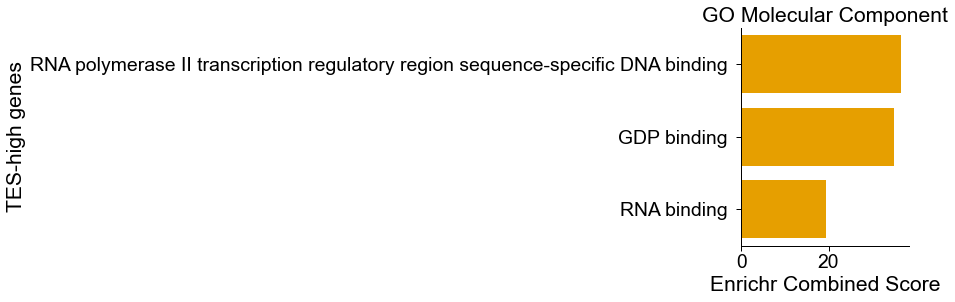

In [34]:
# tes - show molecular function
df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)
n = 4
kind = 'tes'
# df = df.head(n)
df = df.iloc[[0,3,4]]
df = df.sort_values(by='Combined Score', ascending=False)

df = rm_go_number(df)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TES-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

In [35]:
# # tes - show molecular function
# df = pd.read_csv('obs_major_tes_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
# # df = df.sort_values(by='Adjusted P-value', ascending=True)
# # n = 2
# kind = 'tes'
# # df = df.head(n)
# df = df.iloc[[0,3]]

# df = df.sort_values(by='Combined Score', ascending=False)

# df = rm_go_number(df)
# color = get_sector_colors()[0][kind]


# sns.set_context('paper', font_scale=2.2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
# plt.figure(figsize=(3,4))
# ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set(title='GO Molecular Component')

# xlabel = 'Enrichr Combined Score'
# ylabel = 'TES-high genes'

# _ = ax.set(xlabel=xlabel, ylabel=ylabel)
# fname = 'obs_major_tes_genes_GO/molecular_component_bar.pdf'
# plt.savefig(fname, dpi=500, bbox_inches='tight')

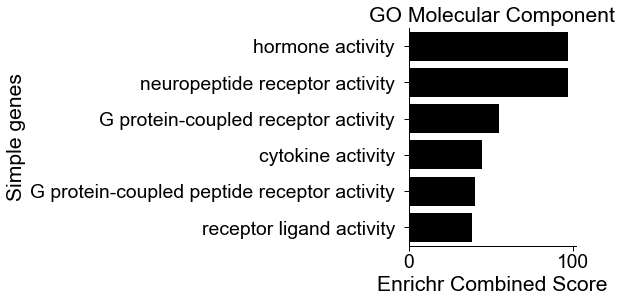

In [37]:
# simple - show molecular function
df = pd.read_csv('obs_major_simple_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'simple'
df = df.sort_values(by='Adjusted P-value', ascending=True)
df = df.head(n)

df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Simple genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_simple_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

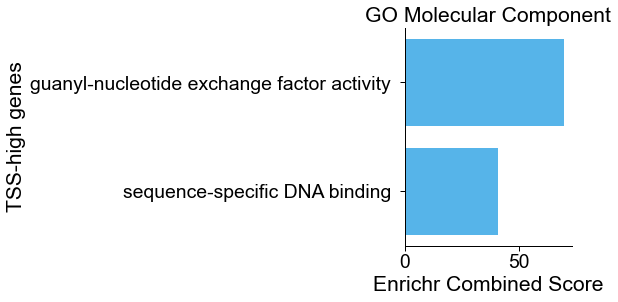

In [32]:
# tss - show molecular function
df = pd.read_csv('obs_major_tss_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
n = 6
kind = 'tss'


df = rm_go_number(df)
# df = df.sort_values(by='Combined Score', ascending=False)
df = df.sort_values(by='Adjusted P-value', ascending=True)
# import pdb; pdb.set_trace()
df = df.iloc[[0,1]]
df = df.head(n)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'TSS-high genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_tss_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

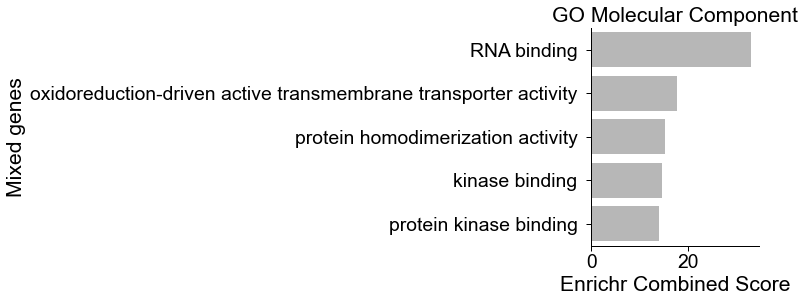

In [39]:
# mixed - show molecular function
df = pd.read_csv('obs_major_mixed_genes_GO/GO_Molecular_Function_2021.Human.enrichr.reports.txt', sep='\t')
df = df.sort_values(by='Adjusted P-value', ascending=True)

n = 5
kind = 'mixed'
df = df.head(n)

df = rm_go_number(df)
df = df.sort_values(by='Combined Score', ascending=False)
color = get_sector_colors()[0][kind]


sns.set_context('paper', font_scale=2.2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=df, x='Combined Score', y='term', color=color, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(title='GO Molecular Component')

xlabel = 'Enrichr Combined Score'
ylabel = 'Mixed genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = 'obs_major_mixed_genes_GO/molecular_component_bar.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')